In [132]:
import nsaba.nsaba as na
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from tabulate import tabulate
import numpy as np
import scipy as sp
import random as rn

import matplotlib as mt
import matplotlib.pyplot as plt
mt.style.use('ggplot')
%matplotlib inline

In [2]:
dd = '../../data_dir'
na.Nsaba.aba_load(dd)
na.Nsaba.ns_load(dd)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [3]:
na.Nsaba.ns_load_id_dict()

This may take a minute or two ...


In [4]:
para = na.Nsaba()
para.load_ge_pickle('Nsaba_ABA_ge.pkl', dd)

This may take a minute or two ...
'ge' dictionary successfully loaded


In [5]:
feat_df = para.get_ns_struct("features_df")

# Term Activation

In [124]:
terms = ['reward', 'attention', 'memory', 'motor']
dfs = []
for term in terms:
    _, df = para._term_to_coords(term, -1)
    dfs.append(df)

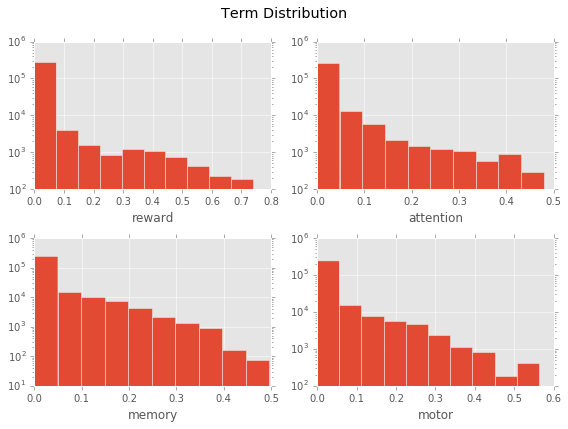

In [125]:
plt.suptitle("Term Distribution", fontsize='x-large');
for term, sb, df in zip(terms, range(221,225), dfs):
    plt.subplot(sb)
    df[term].hist(bins=10, figsize=(8,6));
    plt.yscale('log');
    plt.xlabel(term);

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [162]:
# Validation Helpers
def plot_vc(pars, train_scores, valid_scores, score, par_name, subplot, term):
    plt.subplot(subplot)
    plt.title(term)
    plt.plot(pars, np.mean(train_scores,1), label="Train")
    plt.plot(pars, np.mean(valid_scores,1), label="Validation")
    plt.legend()
    plt.xlabel(par_name);
    plt.ylabel(score);
    
def print_score(terms, pars, train_scores_, valid_scores_, par_name, error=True):
    entries = []
    if error:
        headers = ["Term", par_name, "Mean Training Error", "Mean CV Error"]
    else:
        headers = ["Term", par_name, "Mean Training Score", "Mean CV Score"]
    for tscores, vscores, term in zip(train_scores_, valid_scores_, terms):
        if error:
            t_means = -np.mean(train_scores,1)
            v_means = -np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
        else:
            t_means = np.mean(train_scores,1)
            v_means = np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
    print tabulate(entries, headers=headers)

# Decision Tree

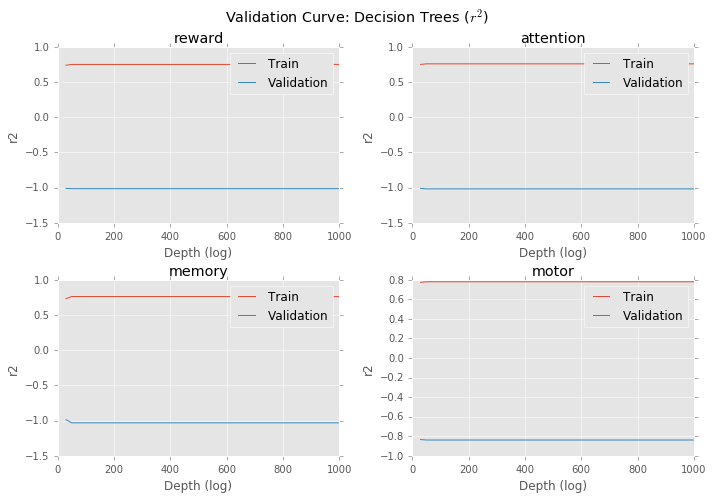

In [177]:
depth=[30,50,100,1000]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  X, y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, train_scores, valid_scores, 
            score, "Depth (log)", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [173]:
print_score(terms, depth, train_scores_, valid_scores_, "Max Depth", error=False)

Term         Max Depth    Mean Training Score    Mean CV Score
---------  -----------  ---------------------  ---------------
reward              30               0.773692        -0.833702
reward              50               0.779177        -0.838639
reward             100               0.779177        -0.838639
reward            1000               0.779177        -0.838639
attention           30               0.773692        -0.833702
attention           50               0.779177        -0.838639
attention          100               0.779177        -0.838639
attention         1000               0.779177        -0.838639
memory              30               0.773692        -0.833702
memory              50               0.779177        -0.838639
memory             100               0.779177        -0.838639
memory            1000               0.779177        -0.838639
motor               30               0.773692        -0.833702
motor               50               0.779177        -0

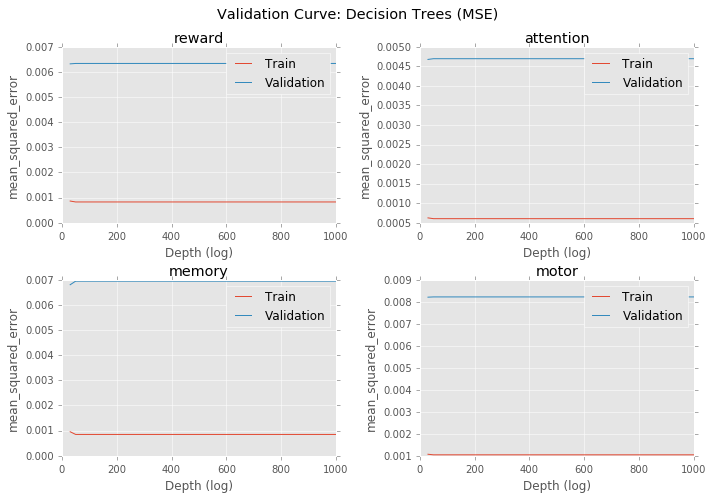

In [176]:
score = 'mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  X, y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, -train_scores, -valid_scores, 
            score, "Depth (log)", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [175]:
print_score(terms, depth, train_scores_, valid_scores_, "Max Depth", error=True)

Term         Max Depth    Mean Training Error    Mean CV Error
---------  -----------  ---------------------  ---------------
reward              30             0.00107068       0.0082081
reward              50             0.00104464       0.00821956
reward             100             0.00104464       0.00821956
reward            1000             0.00104464       0.00821956
attention           30             0.00107068       0.0082081
attention           50             0.00104464       0.00821956
attention          100             0.00104464       0.00821956
attention         1000             0.00104464       0.00821956
memory              30             0.00107068       0.0082081
memory              50             0.00104464       0.00821956
memory             100             0.00104464       0.00821956
memory            1000             0.00104464       0.00821956
motor               30             0.00107068       0.0082081
motor               50             0.00104464       0.00821

# Random Forests

In [ ]:
trees=[10,20,50,100,300]
score = 'r2'

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, train_scores, valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [ ]:
print_score(terms, depth, train_scores_, valid_scores_, "Trees")

  Trees    Mean Training Error    Mean CV Error
-------  ---------------------  ---------------
     10             0.00116657       0.00441523
     20             0.00109228       0.00431277
     50             0.00104873       0.0042167
    100             0.00103335       0.00419386
    300             0.00102362       0.00418152


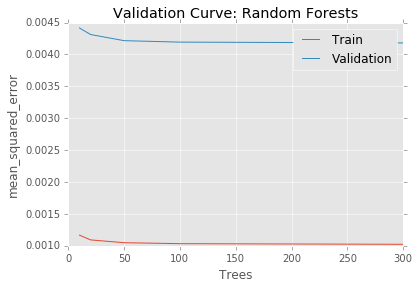

In [103]:
score='mean_squared_error'
plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, -train_scores, -valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [ ]:
print_score(terms, trees, train_scores_, valid_scores_, "Trees")

## KNN

  Neighbors    Mean Training Score    Mean CV Score
-----------  ---------------------  ---------------
          5              0.282331       -0.235675
         10              0.167596       -0.117356
         15              0.12364        -0.0716211
         20              0.101829       -0.0518932
         50              0.0610706      -0.0105955
        100              0.0461084       0.00340413


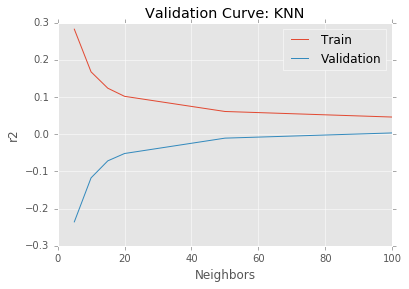

In [107]:
score = 'r2'
neighbors = [5,10,15,20,50,100]

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              X, y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, train_scores, valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [ ]:
print_score(terms, neighbors, train_scores_, valid_scores_, "Neighbors", error=False)

  Neighbors    Mean Training Error    Mean CV Error
-----------  ---------------------  ---------------
          5             0.00235625       0.00399153
         10             0.00273405       0.0036312
         15             0.00287867       0.00349262
         20             0.00295052       0.00343201
         50             0.00308436       0.00330486
        100             0.00313343       0.00326097


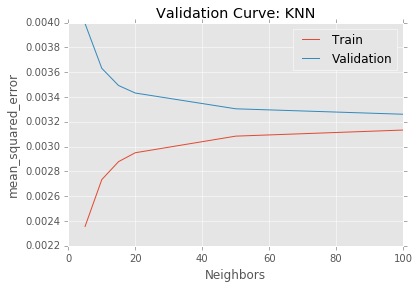

In [108]:
score='mean_squared_error'
plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              X, y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, train_scores, valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [ ]:
print_score(terms, neighbors, train_scores_, valid_scores_, "Neighbors", error=False)